### Code to plot hysteresis for different grain sizes

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from scipy import stats

# turbidity data
turb_SP23 = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/Suspended_Sediment_Analysis/analysis_by_GSD/SP23_clean_complete.csv')
turb_SM23 = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/Suspended_Sediment_Analysis/analysis_by_GSD/SM23_clean_complete.csv')
# GSD data
GSD_SP23 = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/Suspended_Sediment_Analysis/analysis_by_GSD/grain_size_dist/Spring_2023_watercolumn_percentage.csv')
GSD_SM23 = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/Suspended_Sediment_Analysis/analysis_by_GSD/grain_size_dist/Summer_2023_watercolumn_percentage.csv')
# depth and discharge data
depths = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/Suspended_Sediment_Analysis/depth/2023_water_depth.csv')
discharges = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/Suspended_Sediment_Analysis/analysis_by_GSD/hysteresis/discharge_2023.csv')

# suspended sediment concentration data
SSC_SM23 = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/Suspended_Sediment_Analysis/depth/SS_summer2023.csv')
SSC_SP23 = pd.read_csv('C:/Users/huck4481/Documents/GitHub/La_Jara/Suspended_Sediment_Analysis/depth/SS_spring2023.csv')

# Correct datetime conversion and timezone localization
SSC_SM23['Date_Time'] = pd.to_datetime(SSC_SM23['Date_Time']).dt.tz_localize(None)
SSC_SP23['Date_Time'] = pd.to_datetime(SSC_SP23['Date_Time']).dt.tz_localize(None)
turb_SP23['DateTime'] = pd.to_datetime(turb_SP23['DateTime']).dt.tz_localize(None)
turb_SM23['DateTime'] = pd.to_datetime(turb_SM23['DateTime']).dt.tz_localize(None)
# convert the column to floats, ignoring errors
SSC_SM23['SSC (mg/L)'] = pd.to_numeric(SSC_SM23['SSC (mg/L)'], errors='coerce')
SSC_SP23['SSC (mg/L)'] = pd.to_numeric(SSC_SP23['SSC (mg/L)'], errors='coerce')

### Cleanup GSD data

#### Spring

In [5]:
# set first column as index
GSD_SP23.set_index('lab_ID', inplace=True)
# transpose the data
GSD_SP23 = GSD_SP23.T
# separate by upstream and downstream samples for the spring samples
GSD_SP23_up = GSD_SP23[GSD_SP23['sample'].str.startswith('UP')].copy()
GSD_SP23_down = GSD_SP23[GSD_SP23['sample'].str.startswith('D')].copy()
# set date time column in datetime format
GSD_SP23_up.loc[:, 'datetime'] = pd.to_datetime(GSD_SP23_up.loc[:, 'datetime'])
GSD_SP23_down.loc[:, 'datetime'] = pd.to_datetime(GSD_SP23_down.loc[:, 'datetime'])
# sort by date
GSD_SP23_up = GSD_SP23_up.sort_values(by='datetime')
GSD_SP23_down = GSD_SP23_down.sort_values(by='datetime')
# dropping nan values
GSD_SP23_up.replace('-', np.nan, inplace=True)
GSD_SP23_down.replace('-', np.nan, inplace=True)
GSD_SP23_up = GSD_SP23_up.dropna(subset=['sediment (mg)'])
GSD_SP23_down = GSD_SP23_down.dropna(subset=['sediment (mg)'])

## making sure SSC data is compatible with the GSD data
SSC_SP23 = SSC_SP23.drop_duplicates(subset='Date_Time')
# resample the SSC data to every 1min
SSC_SP23_resampled = SSC_SP23.set_index('Date_Time').resample('1T').interpolate() # this is to merge them
# merge SSC dataframes to the GSD dataframes on the same date and time
GSD_SP23_up = pd.merge(GSD_SP23_up, SSC_SP23_resampled, left_on='datetime', right_index=True, how='inner')
GSD_SP23_down = pd.merge(GSD_SP23_down, SSC_SP23_resampled, left_on='datetime', right_index=True, how='inner')

# merge discharge data with the SSC data
discharges['Date_Time'] = pd.to_datetime(discharges['Date_Time']).dt.tz_localize(None)
discharges.set_index('Date_Time', inplace=True)
# resample to every 1 minute and interpolate
discharges = discharges.resample('1T').interpolate()

SSC_SP23 = pd.merge(SSC_SP23, discharges['Q'], left_on='Date_Time', right_index=True, how='inner')
GSD_SP23_up = pd.merge(GSD_SP23_up, discharges['Q'], left_on='datetime', right_index=True, how='inner')

In [6]:
# print the SSC (mg/L) columns (one is called SSC (mg/L)_x and the other is called SSC (mg/L)_y)
print(GSD_SP23_down[['SSC (mg/L)_x', 'SSC (mg/L)_y']]) 
# the first corresponds to the actual measured concentrations, whereas the second corresponds to the interpolated values from the turbidity record

    SSC (mg/L)_x  SSC (mg/L)_y
205       23.158      2.105586
206           15     17.306593
222        8.947     12.113447
207          9.5     10.881393
225           23     26.236767
226           15     15.605993
227           10      8.867347
229          3.5      8.958740
234         6.25      6.172633
323           42     37.763840
324       17.419     18.623880
327            6     10.675167
343       22.143     18.243520
344           10     10.692280
345        6.429      6.676220
346           18      8.539780
350       20.667     19.951033
351       11.875     12.868600
356        7.143      6.138367


The first (SSC (mg/L)_x) corresponds to the actual measured concentrations, whereas the second (SSC (mg/L)_y) corresponds to the interpolated values from the turbidity record

#### Summer

In [8]:
# set first column as index
GSD_SM23.set_index('lab_ID', inplace=True)
# transpose the data
GSD_SM23 = GSD_SM23.T
# separate by upstream and downstream samples for the spring samples
GSD_SM23_up = GSD_SM23[GSD_SM23['sample'].str.contains('-U')].copy()
GSD_SM23_down = GSD_SM23[GSD_SM23['sample'].str.contains('-D')].copy()
# set date time column in datetime format
GSD_SM23_up.loc[:, 'datetime'] = pd.to_datetime(GSD_SM23_up.loc[:, 'datetime'])
GSD_SM23_down.loc[:, 'datetime'] = pd.to_datetime(GSD_SM23_down.loc[:, 'datetime'])
# sort by date
GSD_SM23_up = GSD_SM23_up.sort_values(by='datetime')
GSD_SM23_down = GSD_SM23_down.sort_values(by='datetime')
# dropping nan values
GSD_SM23_up.replace('-', np.nan, inplace=True)
GSD_SM23_down.replace('-', np.nan, inplace=True)
GSD_SM23_up = GSD_SM23_up.dropna(subset=['sediment (mg)'])
GSD_SM23_down = GSD_SM23_down.dropna(subset=['sediment (mg)'])

## making sure SSC data is compatible with the GSD data
SSC_SM23 = SSC_SM23.drop_duplicates(subset='Date_Time')
# resample the SSC data to every 1min
SSC_SM23_resampled = SSC_SM23.set_index('Date_Time').resample('1T').interpolate() # this is to merge them

# merge SSC dataframes to the GSD dataframes on the same date and time
GSD_SM23_up = pd.merge(GSD_SM23_up, SSC_SM23_resampled, left_on='datetime', right_index=True, how='inner')
GSD_SM23_down = pd.merge(GSD_SM23_down, SSC_SM23_resampled, left_on='datetime', right_index=True, how='inner')

# converting the SSC (mg/L) column to numeric
GSD_SP23_up['SSC (mg/L)_x'] = pd.to_numeric(GSD_SP23_up['SSC (mg/L)_x'], errors='coerce')
GSD_SP23_down['SSC (mg/L)_x'] = pd.to_numeric(GSD_SP23_down['SSC (mg/L)_x'], errors='coerce')
GSD_SP23_up['SSC (mg/L)_y'] = pd.to_numeric(GSD_SP23_up['SSC (mg/L)_y'], errors='coerce')
GSD_SP23_down['SSC (mg/L)_y'] = pd.to_numeric(GSD_SP23_down['SSC (mg/L)_y'], errors='coerce')
# same for the summer 
GSD_SM23_up['SSC (mg/L)_x'] = pd.to_numeric(GSD_SM23_up['SSC (mg/L)_x'], errors='coerce')
GSD_SM23_down['SSC (mg/L)_x'] = pd.to_numeric(GSD_SM23_down['SSC (mg/L)_x'], errors='coerce')
GSD_SM23_up['SSC (mg/L)_y'] = pd.to_numeric(GSD_SM23_up['SSC (mg/L)_y'], errors='coerce')
GSD_SM23_down['SSC (mg/L)_y'] = pd.to_numeric(GSD_SM23_down['SSC (mg/L)_y'], errors='coerce')

# print the SSC (mg/L) columns (one is called SSC (mg/L)_x and the other is called SSC (mg/L)_y)
print(GSD_SM23_down[['SSC (mg/L)_x', 'SSC (mg/L)_y']]) 

# merge discharges with the SSC data
SSC_SM23 = pd.merge(SSC_SM23, discharges['Q'], left_on='Date_Time', right_index=True, how='inner')
GSD_SM23_up = pd.merge(GSD_SM23_up, discharges['Q'], left_on='datetime', right_index=True, how='inner')

     SSC (mg/L)_x  SSC (mg/L)_y
440       110.000    102.021200
441        53.333     96.578800
442        80.000     91.024400
443        43.333     67.307000
444        92.222     51.258000
456        76.154     56.327000
457        41.200     36.296600
458        39.600     31.388200
459        27.600     24.603000
460        20.833     17.576067
484        37.600     30.925400
485        31.538     31.979600
486        28.077     27.930800
487        23.600     24.378600
488        21.176     21.049400


### Plot turbidity and SSC concentration time series

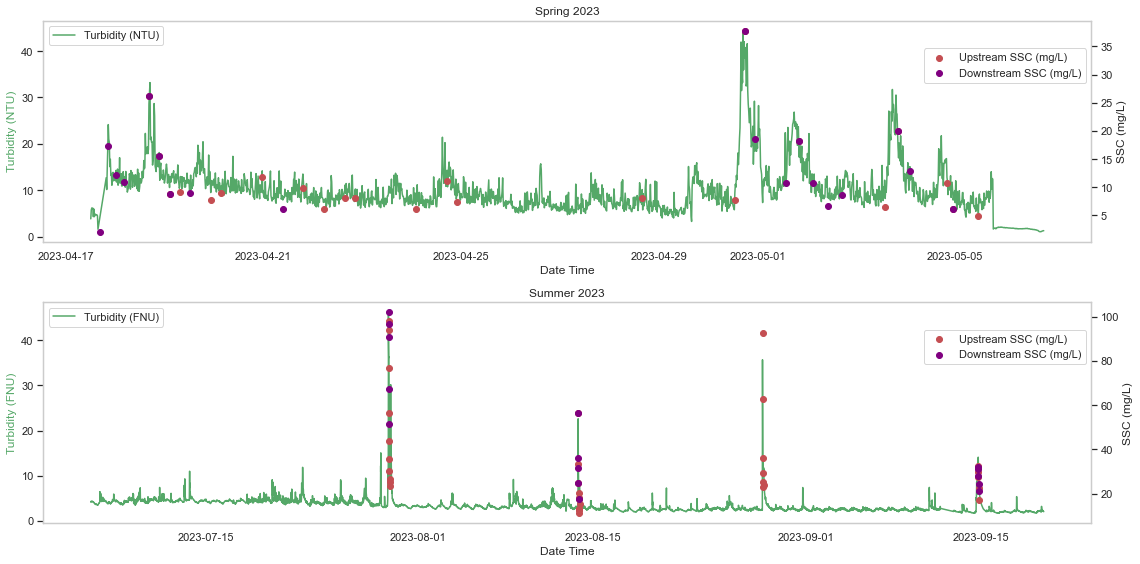

In [10]:
# Plot turbidity and SSC concentration time series for both seasons 
sns.set(style='whitegrid')
fig, ax1 = plt.subplots(2, 1, figsize=(16, 8)) 

# spring
ax2 = ax1[0].twinx()  # create a second y-axis for the SSC concentration
ax1[0].plot(turb_SP23['DateTime'], turb_SP23['Upstream'], 'g-', label='Turbidity (NTU)')
ax2.scatter(GSD_SP23_up['datetime'], GSD_SP23_up['SSC (mg/L)_y'], c='r', marker='o', label='Upstream SSC (mg/L)')
ax2.scatter(GSD_SP23_down['datetime'], GSD_SP23_down['SSC (mg/L)_y'], c='purple', marker='o', label='Downstream SSC (mg/L)')

ax1[0].set_xlabel('Date Time')
ax1[0].set_ylabel('Turbidity (NTU)', color='g')
ax2.set_ylabel('SSC (mg/L)')
ax1[0].set_title('Spring 2023')
ax1[0].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9)) 
ax1[0].grid(False)
ax2.grid(False)

# Summer
ax2 = ax1[1].twinx()  # create a second y-axis for the SSC concentration
ax1[1].plot(turb_SM23['DateTime'], turb_SM23['Upstream'], 'g-', label='Turbidity (FNU)')
ax2.scatter(GSD_SM23_up['datetime'], GSD_SM23_up['SSC (mg/L)_y'], c='r', marker='o', label='Upstream SSC (mg/L)')
ax2.scatter(GSD_SM23_down['datetime'], GSD_SM23_down['SSC (mg/L)_y'], c='purple', marker='o', label='Downstream SSC (mg/L)')

ax1[1].set_xlabel('Date Time')
ax1[1].set_ylabel('Turbidity (FNU)', color='g')
ax2.set_ylabel('SSC (mg/L)')
ax1[1].set_title('Summer 2023')
ax1[1].legend(loc='upper left')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax1[1].grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()

### Grouping by grain sizes 

In [11]:
# first I need to merge turbidity data with the GSD data
# set date time as index and make sure its in datetime format
turb_SP23['DateTime'] = pd.to_datetime(turb_SP23['DateTime'])
turb_SM23['DateTime'] = pd.to_datetime(turb_SM23['DateTime'])
# resample the turbidity data to every 1 minute
turb_SP23 = turb_SP23.drop_duplicates(subset='DateTime').set_index('DateTime').resample('1T').interpolate()
turb_SM23 = turb_SM23.drop_duplicates(subset='DateTime').set_index('DateTime').resample('1T').interpolate()
# merge the turbidity data with the GSD data
GSD_SP23_up = pd.merge(GSD_SP23_up, turb_SP23, left_on='datetime', right_index=True, how='inner')
GSD_SM23_up = pd.merge(GSD_SM23_up, turb_SM23, left_on='datetime', right_index=True, how='inner')
# change the turbidity column name to avoid confusion
GSD_SP23_up.rename(columns={'Upstream': 'Turbidity (NTU)'}, inplace=True)
GSD_SM23_up.rename(columns={'Upstream': 'Turbidity (FNU)'}, inplace=True)

#### Spring

In [12]:
# convert columns to numeric, coercing errors to NaN, then filling NaN with 0
for col in range(6, 49):  # this is the range my GS data is in
    GSD_SP23_up.iloc[:, col] = pd.to_numeric(GSD_SP23_up.iloc[:, col], errors='coerce').fillna(0)

# sum values for each sediment type based on the provided column ranges
GSD_SP23_up['Clay'] = GSD_SP23_up.iloc[:, 6:17].sum(axis=1)
GSD_SP23_up['Silt'] = GSD_SP23_up.iloc[:, 17:31].sum(axis=1)
GSD_SP23_up['Fine_Sand'] = GSD_SP23_up.iloc[:, 31:45].sum(axis=1)
GSD_SP23_up['Coarse_Sand'] = GSD_SP23_up.iloc[:, 45:49].sum(axis=1)

# those are just percentages, so I need to multiply them by the SSC values 
GSD_SP23_up['Clay'] = GSD_SP23_up['Clay'] * GSD_SP23_up['SSC (mg/L)_x']
GSD_SP23_up['Silt'] = GSD_SP23_up['Silt'] * GSD_SP23_up['SSC (mg/L)_x']
GSD_SP23_up['Fine_Sand'] = GSD_SP23_up['Fine_Sand'] * GSD_SP23_up['SSC (mg/L)_x']
GSD_SP23_up['Coarse_Sand'] = GSD_SP23_up['Coarse_Sand'] * GSD_SP23_up['SSC (mg/L)_x']

# calculate fine over sand ratio
GSD_SP23_up['Fine/Sand'] = (GSD_SP23_up['Clay'] + GSD_SP23_up['Silt']) / (GSD_SP23_up['Fine_Sand'] + GSD_SP23_up['Coarse_Sand'])

Plot spring by grain size

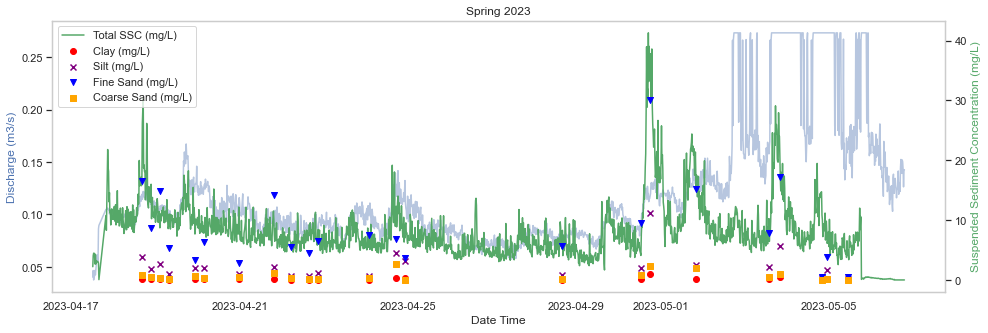

In [13]:
# Plot turbidity and SSC concentration time series for both seasons 
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(16, 5))

# plot water depth
ax.plot(SSC_SP23['Date_Time'], SSC_SP23['Q'], 'b-', alpha=0.4, zorder=1)
ax2 = ax.twinx()  # create a second y-axis for the SSC concentration
ax2.plot(SSC_SP23['Date_Time'], SSC_SP23['SSC (mg/L)'], 'g-', label='Total SSC (mg/L)', zorder=2)
ax2.scatter(GSD_SP23_up['datetime'], GSD_SP23_up['Clay'], c='red', marker='o', label='Clay (mg/L)', zorder=3)
ax2.scatter(GSD_SP23_up['datetime'], GSD_SP23_up['Silt'], c='purple', marker='x', label='Silt (mg/L)', zorder=4)
ax2.scatter(GSD_SP23_up['datetime'], GSD_SP23_up['Fine_Sand'], c='blue', marker='v', label='Fine Sand (mg/L)', zorder=5)
ax2.scatter(GSD_SP23_up['datetime'], GSD_SP23_up['Coarse_Sand'], c='orange', marker='s', label='Coarse Sand (mg/L)', zorder=6)

ax.set_xlabel('Date Time')
ax.set_ylabel('Discharge (m3/s)', color='b')
ax2.set_ylabel('Suspended Sediment Concentration (mg/L)', color='g')
ax.set_title('Spring 2023')
ax2.legend(loc='upper left') 
ax.grid(False)
ax2.grid(False)

plt.show()

Time series plot by grain sizes (separated)

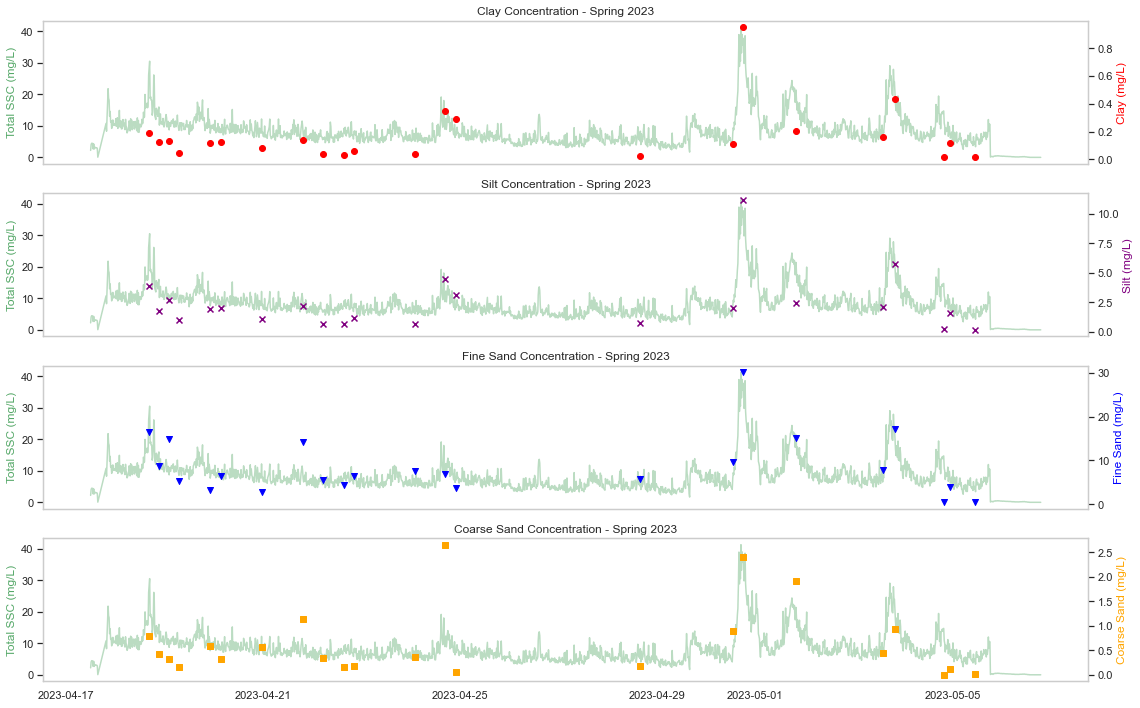

In [14]:
sns.set(style='whitegrid')
fig, axs = plt.subplots(4, 1, figsize=(16, 10), sharex=True)

# plot for clay
axs[0].plot(SSC_SP23['Date_Time'], SSC_SP23['SSC (mg/L)'], 'g-', alpha=0.4, zorder=1)
axs_clay = axs[0].twinx()
axs_clay.scatter(GSD_SP23_up['datetime'], GSD_SP23_up['Clay'], c='red', marker='o', label='Clay (mg/L)', zorder=3)
axs_clay.set_ylabel('Clay (mg/L)', color='red')
axs[0].set_title('Clay Concentration - Spring 2023')
# plot for silt
axs[1].plot(SSC_SP23['Date_Time'], SSC_SP23['SSC (mg/L)'], 'g-', alpha=0.4, zorder=1)
axs_silt = axs[1].twinx()
axs_silt.scatter(GSD_SP23_up['datetime'], GSD_SP23_up['Silt'], c='purple', marker='x', label='Silt (mg/L)', zorder=4)
axs_silt.set_ylabel('Silt (mg/L)', color='purple')
axs[1].set_title('Silt Concentration - Spring 2023')
# plot for fine sand
axs[2].plot(SSC_SP23['Date_Time'], SSC_SP23['SSC (mg/L)'], 'g-', alpha=0.4, zorder=1)
axs_fine_sand = axs[2].twinx()
axs_fine_sand.scatter(GSD_SP23_up['datetime'], GSD_SP23_up['Fine_Sand'], c='blue', marker='v', label='Fine Sand (mg/L)', zorder=5)
axs_fine_sand.set_ylabel('Fine Sand (mg/L)', color='blue')
axs[2].set_title('Fine Sand Concentration - Spring 2023')
# plot for coarse sand
axs[3].plot(SSC_SP23['Date_Time'], SSC_SP23['SSC (mg/L)'], 'g-', alpha=0.4, zorder=1)
axs_coarse_sand = axs[3].twinx()
axs_coarse_sand.scatter(GSD_SP23_up['datetime'], GSD_SP23_up['Coarse_Sand'], c='orange', marker='s', label='Coarse Sand (mg/L)', zorder=6)
axs_coarse_sand.set_ylabel('Coarse Sand (mg/L)', color='orange')
axs[3].set_title('Coarse Sand Concentration - Spring 2023')
# set labels
plt.xlabel('Date Time')
axs[0].set_ylabel('Total SSC (mg/L)', color='g')
axs[1].set_ylabel('Total SSC (mg/L)', color='g')
axs[2].set_ylabel('Total SSC (mg/L)', color='g')
axs[3].set_ylabel('Total SSC (mg/L)', color='g')
# no grid
axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)
axs_clay.grid(False)
axs_silt.grid(False)
axs_fine_sand.grid(False)
axs_coarse_sand.grid(False)

plt.tight_layout()
plt.show()